# 泊松过程 {#sec-poisson}

## Gamma 分布

首先，我建议大家把我在博客讲过的 [离散分布](https://hongtaoh.com/cn/2024/03/23/discrete-distributions/)先理解透，特别是泊松分布那一部分。

在泊松分布中我们讲到这样一个问题：

>中国男足队平均每场比赛进 5 个球 (请允许我在平行宇宙做一次梦)，请问下一场比赛中国进 2 个球的概率是多少

我们用泊松分布模拟了中国队进 0-10 个球的概率：

$$
P(X = k) = \frac{\lambda^k \cdot e^{-\lambda}}{k!}
$$ {#eq-poisson}

In [1]:
from scipy.stats import poisson
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

def normalize_array(arr):
    return np.array([i/np.sum(arr) for i in arr])

lam = 5
dist = poisson(lam)
pmfs = [dist.pmf(i) for i in range(11)]

Text(0.5, 1.0, 'Poisson Distribution of Goals ($\\lambda=5$)')

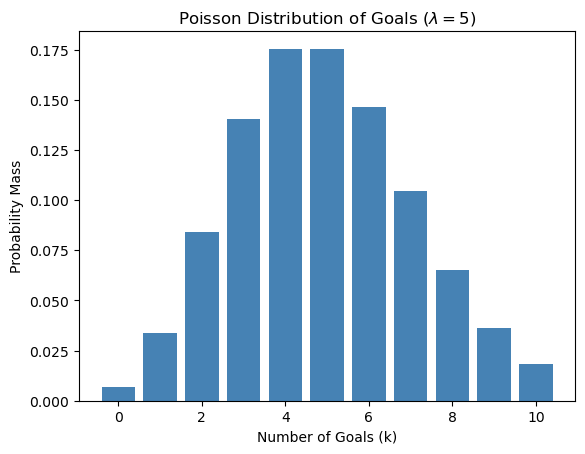

In [2]:
#| code-fold: true

x_axis = range(11)
plt.bar(x_axis, pmfs, color='steelblue', label=r'Poisson distribution with `$\lambda=5$`')
plt.xlabel("Number of Goals (k)")
plt.ylabel("Probability Mass")
plt.title(f"Poisson Distribution of Goals ($\lambda=5$)")

使用泊松分布，我们可以由 $\lambda$ 得知 $p(k)$，也就是 $P(k|\lambda)$。那现在的问题是，我们如何求 $P(\lambda | k)$:

>中国队在一场球赛中进了 2 个球 ($k=2$)，请问中国队平常一般进多少个球 ($\lambda$)？

根据贝叶斯定理：

$$
P(\lambda | k) = \frac{P(\lambda) P(k|\lambda)}{P(k)}
$$ {#eq-lambda-given-k}

这里

- $k$ 是数据
- $\lambda$ 是假设
- $P(\lambda)$ 是先验概率
- $P(k|\lambda)$ 是似然

我们可以先忽略 $P(k)$，因为它只是为了让最后的结果之和为 1。

::: {.callout-tip}

为什么我们可以忽略 $P(k)$ 呢？因为它是一个常量：

$$
P(k) = \sum_{\lambda} P(k|\lambda) \cdot P(\lambda)
$$

我们最后让 posteior 和为一的时候，也是要对所有的结果乘上一个常量。那我们最后再做就好，没有必要这时候乘。

:::

$P(k|\lambda)$ 可以通过泊松分布来求得。现在比较难弄的是 $P(\lambda)$，也就是我们还没看任何数据时对球队一般进球的预估。

我们用 [FIFA 的数据](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/) (世界杯场均进分数据)：

In [3]:
df = pd.read_csv('public/data/fifa.csv')
df.head()

,year,lam
0,1930,3.89
1,1934,4.12
2,1938,4.67
3,1950,4.00
4,1954,5.38


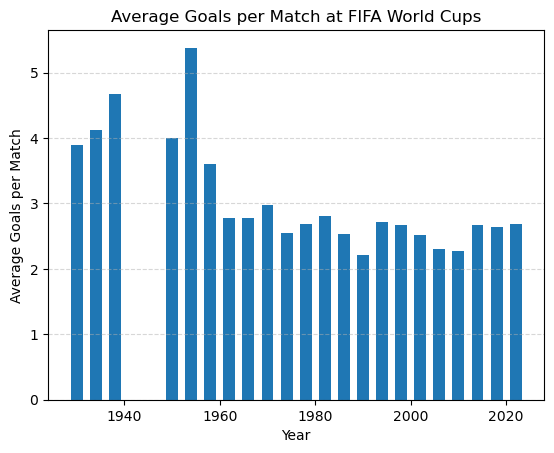

In [4]:
#| code-fold: true
plt.bar(df.year, df.lam, width=2.5)
plt.xlabel("Year")
plt.ylabel("Average Goals per Match")
plt.title("Average Goals per Match at FIFA World Cups")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [5]:
np.mean(df.lam)

3.065909090909091

我们看到一场球平均进 3 个球。那我们大概就有数了。但是 Prior 不能只是一个数，需要是一个分布，我们用 [Gamma 分布](https://en.wikipedia.org/wiki/Gamma_distribution)来模拟。该分布有两个变量：$\alpha$ (shape) 和 $\beta$ (rate)。该分布的平均值为 $\frac{\alpha}{\beta}$，Probability Density Function (PDF) 是

$$
f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} x^{\alpha - 1} e^{-\beta x} 
$$ {#eq-gamma}

其中

$$
x \in (0, \infty)
$$

其中 $\Gamma(\alpha)$ 的定义是：

$$
\Gamma(\alpha) = \int_0^{\infty} x^{\alpha - 1} e^{-x} \, dx
$$

$\Gamma(\alpha)$ 其实是连乘 (factorial) 在非整数中的应用。如果 $n$ 是整数，那

$$\Gamma(n) = (n - 1)!$$

如果是非整数，比如 $0.5$，那就需要用上面的那个普遍公式。

为什么用 Gamma 分布？

- 因为它的自变量是从 0 开始的。
- 如果我们把 $\beta$ 预设为 1，那么就只剩下一个变量 $\alpha$，这个就是上面算出来的 3 个球。
- 结果符合现实情况。

所以以下就是 Prior:

In [6]:
from scipy.stats import gamma

alpha_prior = 3

# assume it is almost impossible to score more than 10 
lambdas = np.linspace(0, 10, 101)
delta_lambda = lambdas[1] - lambdas[0]

# probability mass function
prior_pmf = gamma(alpha_prior).pdf(lambdas)*delta_lambda

# normalize the prior for visualization purposes
# note that the posterior is the same whether we normalize prior or not
prior_pmf = normalize_array(prior_pmf) 

::: {.callout-tip}

注意，`gamma(alpha_prior).pdf(lambdas)` 算的是 PDF，要乘以间隔才是 PMF (probability mass function)。

:::

In [7]:
np.sum(prior_pmf)

0.9999999999999997

Likelihood，也就是已知 $\lambda$ 求 $k$:

In [8]:
k = 2
likelihood_pmf = poisson(lambdas).pmf(k)
likelihood_pmf[0:5]

array([0.        , 0.00452419, 0.01637462, 0.03333682, 0.0536256 ])

那求 Posterior 就是 Prior 和 Likelihood 这两个数列逐元素相乘，然后让最后的结果之和为1就可以：

In [9]:
posterior = normalize_array(prior_pmf * likelihood_pmf)

Text(0.5, 1.0, 'Prior and Posterior Distribution of $\\lambda$')

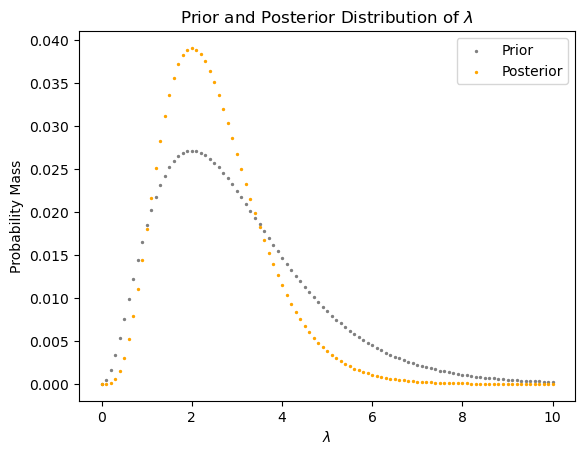

In [10]:
#| code-fold: true
plt.scatter(x = lambdas, 
            y = prior_pmf, 
            s = 2, 
            color="grey", 
            label="Prior")
plt.scatter(x = lambdas, 
            y = posterior, 
            s = 2, 
            color = "orange", 
            label="Posterior")
plt.xlabel(r"$\lambda$")
plt.ylabel("Probability Mass")
plt.legend()
plt.title(r"Prior and Posterior Distribution of $\lambda$")

## Probability of Superiority

>德国男足最近的一场比赛射进 4 个球，巴西队最近一场比赛射进 2 个球。我们有多大信心说德国男足更强？

我们首先要把各自队的 posterior 求出来：

In [11]:
def get_posterior_pmf(lambdas, k, prior_pmf):
    likelihood_pmf = poisson(lambdas).pmf(k)
    posterior = normalize_array(
        prior_pmf * likelihood_pmf)
    return posterior

In [12]:
ge_posterior_pmf = get_posterior_pmf(lambdas, 4, prior_pmf)
br_posterior_pmf = get_posterior_pmf(lambdas, 2, prior_pmf)

Text(0.5, 1.0, 'Posterior Distribution')

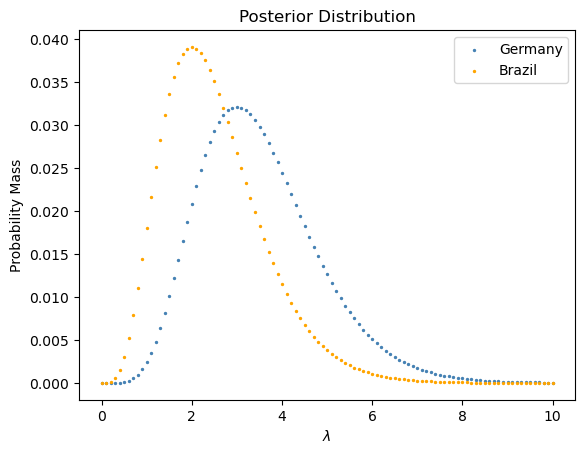

In [13]:
#| code-fold: true
plt.scatter(x = lambdas, 
            y = ge_posterior_pmf, 
            s = 2, 
            color="steelblue", 
            label="Germany")
plt.scatter(x = lambdas, 
            y = br_posterior_pmf, 
            s = 2, 
            color = "orange", 
            label="Brazil")
plt.xlabel(r"$\lambda$")
plt.ylabel("Probability Mass")
plt.legend()
plt.title(r"Posterior Distribution")

这里 $\lambda$ 所代表的是一个国家队平均而言每场得多少分。

总体思路是这样：德国队随机一个 $\lambda$，巴西队也随机选一个，德国对应的 $\lambda$ 比巴西的大的概率。

算法如下：

$$
P(\lambda_{\text{Germany}} > \lambda_{\text{Brazil}}) = \sum_{\lambda_{\text{Germany}}} \sum_{\lambda_{\text{Brazil}}} P(\lambda_{\text{Germany}}) \cdot P(\lambda_{\text{Brazil}}) \cdot \mathbb{I}(\lambda_{\text{Germany}} > \lambda_{\text{Brazil}})
$$

其中 $\mathbb{I}(\lambda_{\text{Germany}} > \lambda_{\text{Brazil}})$ 是 Indicator function，如果 $\lambda_{\text{Germany}} > \lambda_{\text{Brazil}}$ 则 $\mathbb{I}(\lambda_{\text{Germany}} > \lambda_{\text{Brazil}}) = 1$，反之则为 0。


In [14]:
total = 0
for i, lam_ge in enumerate(lambdas):
    for j, lam_br in enumerate(lambdas):
        if lam_ge > lam_br:
            total += ge_posterior_pmf[i] * br_posterior_pmf[j]
total

0.7152072603914539

::: {.callout-tip}

想一下下面这个想法为什么是错的：

```py
sum = 0
for i, lam in enumerate(lambdas):
    if ge_posterior_pmf[i] > br_posterior_pmf[i]:
        sum += 1
```

:::

## Conjugate Priors

我们来讲一个很重要的概念：[Conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior)，中文翻译成「共轭先验」。其所表达的意思是：Posterior Distribution 和 Prior Distribution 同属于一个 Distribution。因为我们的 prior 是 gamma distribution，那 posterior 也是，只是 shape (alpha) 和 rate (beta) 不同。

我们具体来看一下。

在公式 @eq-lambda-given-k 中，求先验概率 $P(\lambda)$ 我们需要用到 @eq-gamma，只需要把 $x$ 换成 $\lambda$ 就可以。求似然 $P(k|\lambda)$ 我们用到 @eq-poisson。

那 $P(\lambda) P(k|\lambda)$ 就是代入具体的 $\lambda$，把 @eq-gamma 和 @eq-poisson 相乘即可。

相乘的结果是：

$$
\frac{\lambda^k \cdot e^{-\lambda}}{k!} \cdot \frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda} = \frac{\beta^\alpha}{\Gamma(\alpha) k!} \cdot \lambda^{(\alpha + k) - 1} e^{-(\beta + 1) \lambda}
$$ {#eq-gamma-times-poisson}

$\frac{\beta^{\alpha}}{\Gamma(\alpha)}$ 是一个常数，$k!$ 也是一个常数。

有这样一个知识：对于一个 Gamma 函数 $\Gamma(\alpha, \frac{1}{\beta})$，曲线下的面积（即分布的积分）为 1。 如果乘上一个常数，比如 $2 \cdot \Gamma(\alpha, \frac{1}{\beta})$，该分布的形状保持不变，但曲线下的面积不再是 1，而是变为该常数的值。

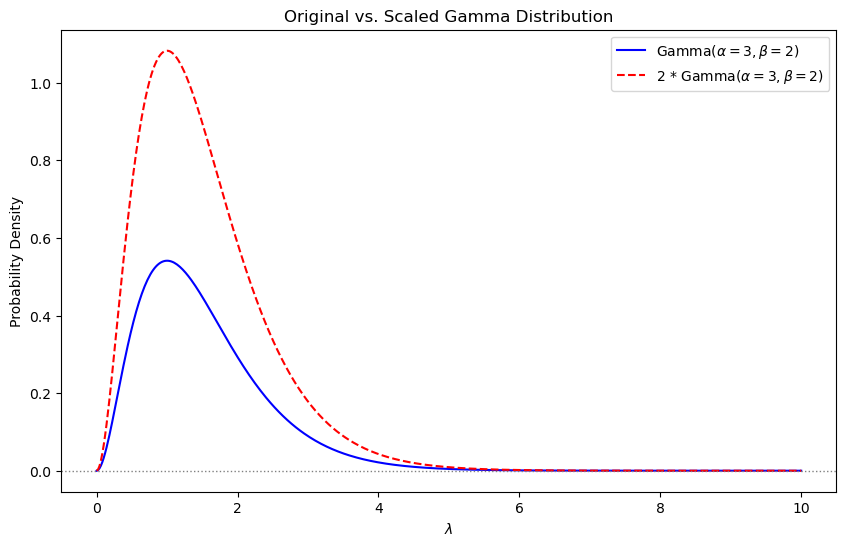

In [15]:
#| code-fold: true
alpha_0 = 3
beta_0 = 2
x = np.linspace(0, 10, 500)
gamma_pdf = gamma.pdf(x, alpha_0, scale = 1/beta_0)
scaled_gamma_pdf = 2 * gamma_pdf

plt.figure(figsize=(10, 6))
plt.plot(x, gamma_pdf, label='Gamma($\\alpha=3, \\beta=2$)', color='blue')
plt.plot(x, scaled_gamma_pdf, 
         label='2 * Gamma($\\alpha=3, \\beta=2$)', 
         color='red', 
         linestyle='--')
plt.axhline(0, color='gray', linestyle=':', linewidth=1)  
plt.xlabel('$\\lambda$')
plt.ylabel('Probability Density')
plt.title('Original vs. Scaled Gamma Distribution')
plt.legend()
plt.show()

那我们就可以理解，在 Gamma 分布中，$\frac{\beta^{\alpha}}{\Gamma(\alpha)}$ 的作用就是让积分为 1。

为了得到 Posterior distribution, 我们要把所有的 $\lambda$ 代入 @eq-gamma-times-poisson，得到一串数字，最后我们要确保它们的和为 1。因此，虽然公式 @eq-gamma-times-poisson 中 \frac{\beta^\alpha}{\Gamma(\alpha) k!} 和 Gamma 函数的不一样，但这个不重要，最后确保和为 1 的时候，它自动就变成了它该有的样子。

因此我们就可以这么说：Posterior Distribution 也是一个 Gamma Distribution，其参数现在变成了 $\alpha + k$ 和 $\beta + 1$：

$$\lambda | k \sim \text{Gamma}(\alpha + k, \beta + 1)$$

代码：

In [16]:
def get_posterior_pmf_conjugate_prior(alpha_prior, beta_prior, k, lambdas):
    """Get posterior pmf through conjugate prior
    """
    delta_lambda = lambdas[1] - lambdas[0]

    alpha_post = alpha_prior + k
    beta_post = beta_prior + 1

    posterior_pdf = gamma(alpha_post, scale=1/beta_post).pdf(lambdas)
    posterior_pmf = posterior_pdf*delta_lambda
    posterior_pmf = normalize_array(posterior_pmf)
    
    return posterior_pmf


In [17]:
ge_posterior_pmf = get_posterior_pmf_conjugate_prior(
    alpha_prior, 1, 4, lambdas)
br_posterior_pmf = get_posterior_pmf_conjugate_prior(
    alpha_prior, 1, 2, lambdas)

Text(0.5, 1.0, 'Posterior Distribution')

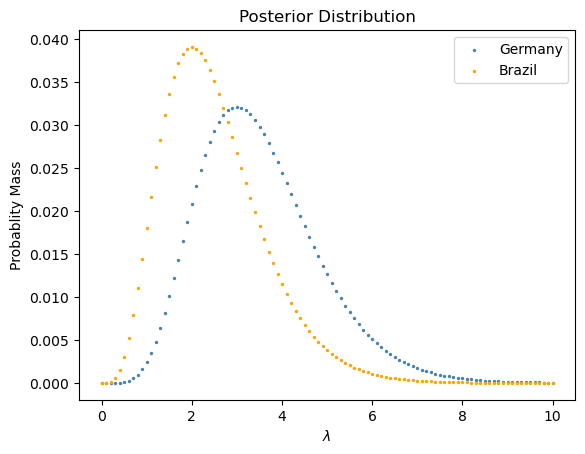

In [18]:
#| code-fold: true
plt.scatter(x = lambdas, 
            y = ge_posterior_pmf, 
            s = 2, 
            color="steelblue", 
            label="Germany")
plt.scatter(x = lambdas, 
            y = br_posterior_pmf, 
            s = 2, 
            color = "orange", 
            label="Brazil")
plt.xlabel(r"$\lambda$")
plt.ylabel("Probablity Mass")
plt.legend()
plt.title(r"Posterior Distribution")

我们看到这个结果和我们通过常规的 Prior 与 Likelihood 相乘所得到的结果是一样的。

## 后验预测分布

我们来讲一下 Posterior predictive distribution (后验预测分布)。

我们看到 Posterior distribution 中，X 轴是 $\lambda$，其含义是平均而言。比如说，$\lambda = 5$ 代表的意思是这个球队如果比赛无数次，平均下来每场会进 5 个球。

回到刚才的德国和巴西男足的叙事，我们现在如果问：

>两队现在马上要进行一场比赛，请问德国对获胜的概率是多少？

请注意，我们现在已经不再是问 $\lambda$，而是问具体的一场比赛中每队的进球数，也就是 $k$。

还记得我们上面提到的吗？

$$
P(k) = \sum_{\lambda} P(k|\lambda) \cdot P(\lambda)
$$

这里 $P(\lambda)$ 是 posterior distribution，$P(k|\lambda)$ 是泊松分布。

In [19]:
def post_predictive_dist(lambdas, posterior_pmfs):
    """compute posterior predictive distribution
    Inputs:
        - lambdas: an numpy array 
        - posterior_pmfs: a numpy array 
    Output:
        - res: a dic where key is k and value is P(k)
    """
    goals = range(int(max(lambdas)))
    res = {}
    for goal in goals:
        total = 0 
        for i, lam in enumerate(lambdas):
            poisson_pmf = poisson(lam).pmf(goal)
            posterior_pmf = posterior_pmfs[i]
            total += poisson_pmf * posterior_pmf
        res[goal] = total 

    normalized_values = normalize_array(np.array(list(res.values())))
    for i, pair in enumerate(res):
        res[i] = normalized_values[i]
    return res

In [20]:
ge_res = post_predictive_dist(lambdas, ge_posterior_pmf)
br_res = post_predictive_dist(lambdas, br_posterior_pmf)

In [21]:
sum(ge_res.values())

1.0

In [22]:
#| code-fold: true
def plot_post_pred_dist(res, cntry_name):
    gaols = list(res.keys())
    probs = list(res.values())
    plt.figure(figsize=(8,5))
    plt.bar(gaols, probs, color="skyblue", edgecolor='black')
    plt.xlabel("Number of Goals (k)")
    plt.ylabel("Probability Mass")
    plt.title(f"Posterior Predictive Distribution of Goals for {cntry_name}")
    plt.show()

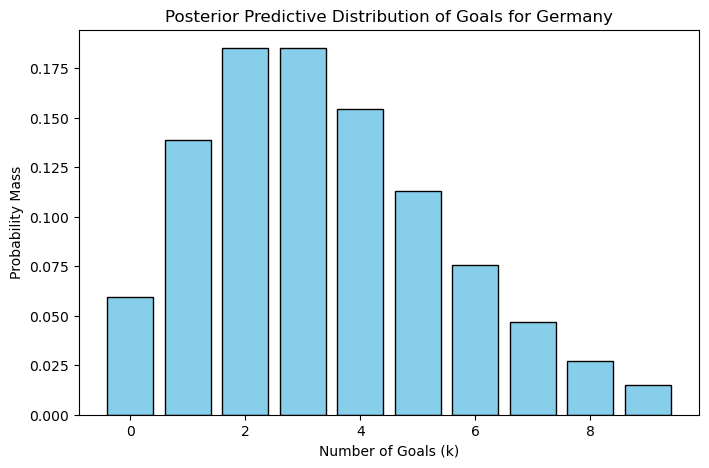

In [23]:
plot_post_pred_dist(ge_res, 'Germany')

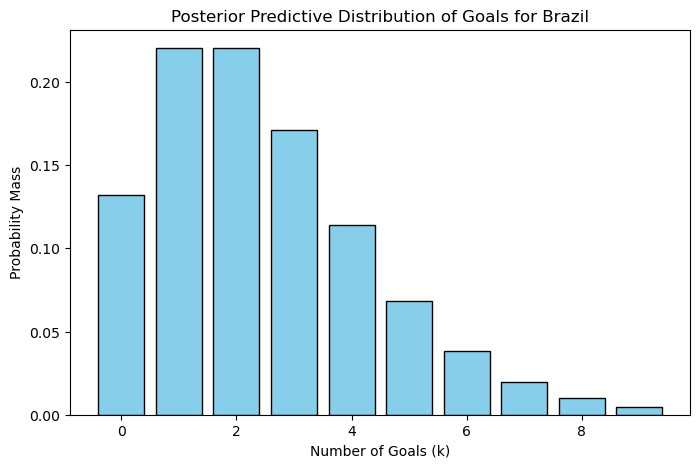

In [24]:
plot_post_pred_dist(br_res, 'Brazil')

下面我们计算一下在下一场比赛中德国队获胜的概率。

总体思路是这样：德国队随机一个 $k$，巴西队也随机选一个，德国对应的 $k$ 比巴西的大的概率。

算法如下：

$$
P(k_{\text{Germany}} > k_{\text{Brazil}}) = \sum_{k} P(k_{\text{Germany}}) \cdot P(k_{\text{Brazil}}) \cdot \mathbb{I}(k_{\text{Germany}} > k_{\text{Brazil}})
$$

In [25]:
def prob_win(res1, res2):
    win_prob = 0
    goals = list(res1.keys())
    for goal1 in goals: 
        for goal2 in goals:
            if goal1 > goal2:
                win_prob += res1[goal1] * res2[goal2]
    return win_prob

In [26]:
prob_win(ge_res, br_res)

0.5582596630665152